# Imports

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import emoji
import collections
from datetime import datetime
# from PIL import Image



# import re
# from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

# Load Data

In [70]:
#open the file

messages = pd.read_pickle('messages.pkl')
messages['created_at'] = pd.to_datetime(messages['created_at'],unit='s').dt.tz_localize('UTC').dt.tz_convert('America/Los_Angeles')
#list(messages)
messages.head()

,attachments,avatar_url,created_at,event,favorited_by,group_id,id,name,sender_id,sender_type,source_guid,system,text,user_id
0,[],https://i.groupme.com/500x500.jpeg.a6ac00ef65e...,2018-12-13 18:41:52-08:00,NaN,[],22733073,154475531298454519,2ndSon,38965011,user,f0be0d525631ff699e0705c559aac48b,False,I copied it to youtube.,38965011
1,[],https://i.groupme.com/500x500.jpeg.a6ac00ef65e...,2018-12-13 18:41:44-08:00,NaN,[],22733073,154475530404448439,2ndSon,38965011,user,29a2b6560ff905ae3aae85d78d8c41fd,False,Here you go 5thsWife - https://www.youtube.com...,38965011
2,[],https://i.groupme.com/638x638.jpeg.115fb32058f...,2018-12-13 15:58:09-08:00,NaN,[],22733073,154474548926793168,5thsWife,48321288,user,4A969769-EB78-4354-A00E-BB62814DB7F5,False,....won’t let me watch it! Hey,48321288
3,[],https://i.groupme.com/1632x918.png.bab44dae5f4...,2018-12-13 15:39:58-08:00,NaN,[38965011],22733073,154474439894152940,5thSon,38964800,user,android-eca69dd2-e52d-4a77-8a70-4176335d16d4,False,https://drive.google.com/file/d/17MWfVdqviGdUp...,38964800
4,[],https://i.groupme.com/907x1300.png.111c73c24d1...,2018-12-13 10:31:39-08:00,NaN,[],22733073,154472589915523168,2ndsWife,38964804,user,android-8006876f-e71a-4ac2-9c94-b732d2237e5b,False,Cuuuuuute! The snow was CRAZY this morning!,38964804


# Analysis

My family has a really active group chat.  Rarely does a day pass that someone doesn't send a message.  Sometimes, I will lose service and return having missed 60+ messages.

With all that data, I thought it would be fun to learn a bit more about my family by looking at their messaging trends.

The family, from my parents to their grandchildren, is comprised of 22 individuals as seen below.  Only 9 of those are active on the group chat (marked in blue).



<img src="files/FamilyTree.png">

In [11]:
dicFdf = {}
s = " ~ "
for person, frame in messages.groupby('name'):
    
    dicFdf[person] = []
    dicFdf[person].append(len(frame))
    dicFdf[person].append(len(frame[frame['attachments'].apply(lambda c: c!=[])]))
    dicFdf[person].append(round(len(frame[frame['attachments'].apply(lambda c: c!=[])])/len(frame)*100,2))
    dicFdf[person].append(frame['favorited_by'].str.len().sum())
    dicFdf[person].append(round(frame['favorited_by'].str.len().sum()/len(frame),2))
    dicFdf[person].append(int(frame['text'].str.split().str.len().sum()))
    dicFdf[person].append(round(int(frame['text'].str.split().str.len().sum())/len(frame),2))
    txt = frame['text'].str.cat(sep=' ')
    dicFdf[person].append(txt)
    
    favEmojstr = []
    emojis = ''.join(c for c in txt if c in emoji.UNICODE_EMOJI)
    favEmojis = collections.Counter(emojis).most_common(5)
    favEmojstr.append(s.join([x[0] for x in favEmojis]))
    dicFdf[person].append(len(emojis))
    dicFdf[person].append(len(emojis)/len(frame))
    dicFdf[person].append(favEmojstr)
    
    
    
    
headerlist = ['Number of Messages', 'Attachments', '% Attachments', 
              'Favorites', 'Favorites per Message', 'Total Words', 
              'Words per Message', 'Messages', 'Number of Emojis', 
              'Emojis per Message', 'Favorite Emojis' ]
                          
perPerson = pd.DataFrame.from_dict(dicFdf, columns=headerlist, orient='index')
perPerson

,Number of Messages,Attachments,% Attachments,Favorites,Favorites per Message,Total Words,Words per Message,Messages,Number of Emojis,Emojis per Message,Favorite Emojis
1stDaughter,3685,695,18.86,6684,1.81,27866,7.56,Go 3rdsHusband!!!!! 🙌🏻🙌🏻🙌🏻🙌🏻🙌🏻🙌🏻 Aaaaallllll d...,3554,0.964450,[😂 ~ 😍 ~ 🎉 ~ 🙌 ~ 💪]
2ndSon,1894,432,22.81,3648,1.93,15410,8.14,I copied it to youtube. Here you go 5thsWife -...,282,0.148891,[😂 ~ 👍 ~ 😉 ~ 😁 ~ 👩]
2ndsWife,1023,189,18.48,2075,2.03,10449,10.21,Cuuuuuute! The snow was CRAZY this morning! I...,814,0.795699,[😂 ~ 🎉 ~ 😍 ~ 😜 ~ 😁]
3rdDaughter,1395,191,13.69,2396,1.72,10797,7.74,Your work looks so big!! 3rdsHusband just won ...,1712,1.227240,[😍 ~ 😂 ~ 🎉 ~ 👍 ~ ❤]
4thDaughter,2006,540,26.92,4923,2.45,17061,8.50,Ha. I thought that was a mall. Don't forget th...,78,0.038883,[😭 ~ 😣 ~ 😢 ~ 😨 ~ 😔]
5thSon,1194,334,27.97,2922,2.45,12234,10.25,https://drive.google.com/file/d/17MWfVdqviGdUp...,111,0.092965,[👍 ~ 😃 ~ 💪 ~ 😎 ~ 😉]
5thsWife,489,200,40.90,1752,3.58,4398,8.99,....won’t let me watch it! Hey HAHAHA Wow. Ju...,766,1.566462,[😂 ~ 👍 ~ 😍 ~ 😉 ~ 🎉]
Dad,1933,383,19.81,3052,1.58,15517,8.03,"Comfy by the fireside. 5thSon, you're not supp...",119,0.061562,[😄 ~ 💞 ~ ⛄ ~ 🙌 ~ ❄]
Mom,1460,263,18.01,2791,1.91,10907,7.47,Love this!!!\nWhat a good Santa! Where do they...,1146,0.784932,[😂 ~ 🎂 ~ 😍 ~ 😊 ~ 😃]


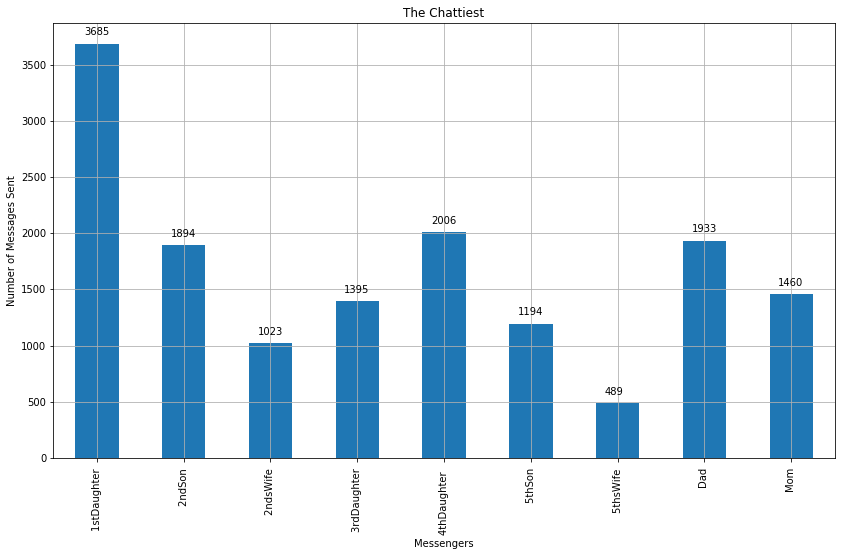

In [12]:
ax = perPerson['Number of Messages'].plot(kind='bar', 
                                grid=True, 
                                figsize=(14,8),
                                title="The Chattiest")
ax.set(xlabel="Messengers", ylabel="Number of Messages Sent")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + .1 , p.get_height() + 75))

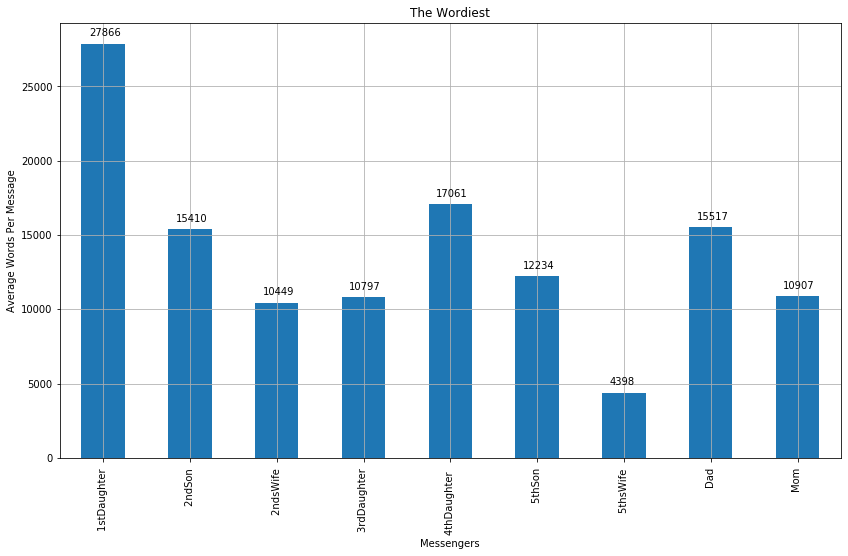

In [13]:
ax = perPerson['Total Words'].plot(kind='bar', 
                                   grid=True, 
                                   figsize=(14,8),
                                   title="The Wordiest")
ax.set(xlabel="Messengers", ylabel="Average Words Per Message")
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),1)), (p.get_x() + .085, p.get_height() + 500))

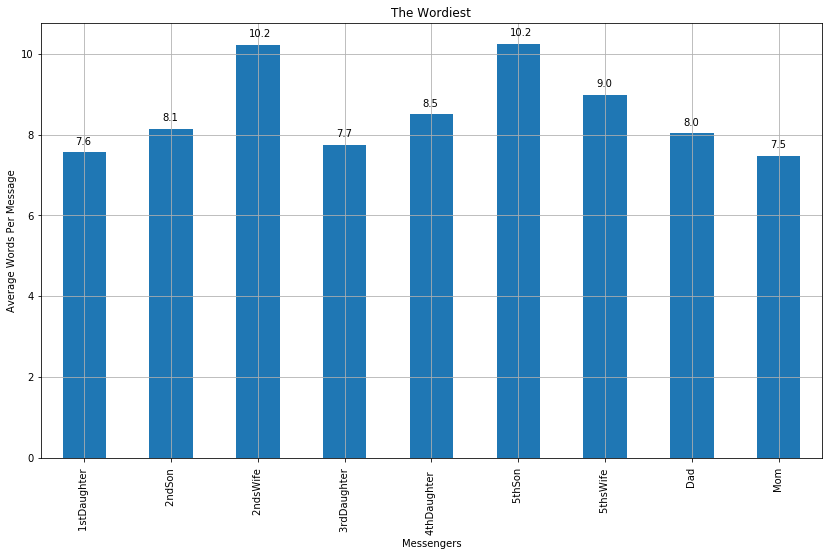

In [14]:
ax = perPerson['Words per Message'].plot(kind='bar', 
                                         grid=True, 
                                         figsize=(14,8),
                                         title="The Wordiest")
ax.set(xlabel="Messengers", ylabel="Average Words Per Message")
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),1)), (p.get_x() + .15, p.get_height() + .2))

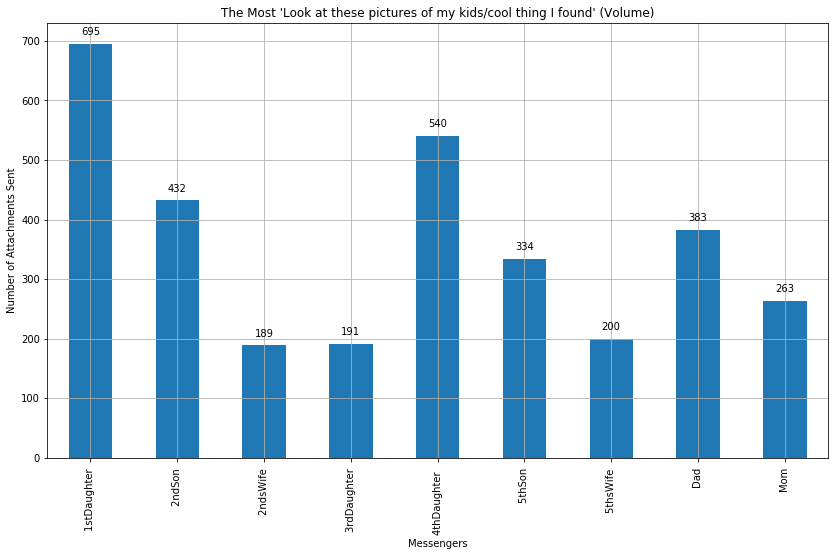

In [15]:
ax = perPerson['Attachments'].plot(kind='bar', 
                                   grid=True, 
                                   figsize=(14,8),
                                   title="The Most 'Look at these pictures of my kids/cool thing I found' (Volume)")
ax.set(xlabel="Messengers", ylabel="Number of Attachments Sent")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + .14, p.get_height() + 15))

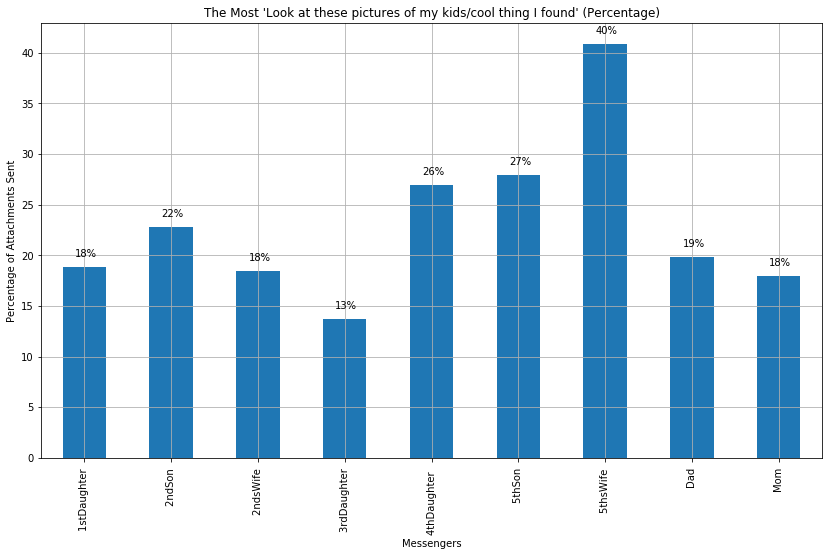

In [16]:
ax = perPerson['% Attachments'].plot(kind='bar', 
                                     grid=True, 
                                     figsize=(14,8),
                                     title="The Most 'Look at these pictures of my kids/cool thing I found' (Percentage)")
ax.set(xlabel="Messengers", ylabel="Percentage of Attachments Sent")
for p in ax.patches:
    ax.annotate(str(int(p.get_height()))+'%', (p.get_x() + .14, p.get_height() + 1))

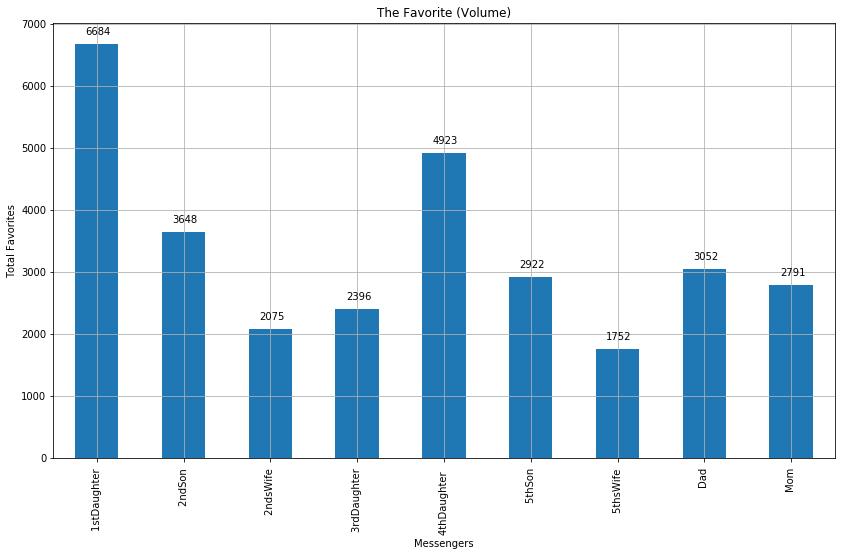

In [17]:
ax = perPerson['Favorites'].plot(kind='bar', grid=True, figsize=(14,8),title="The Favorite (Volume)")
ax.set(xlabel="Messengers", ylabel="Total Favorites")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() +.12, p.get_height() +150))

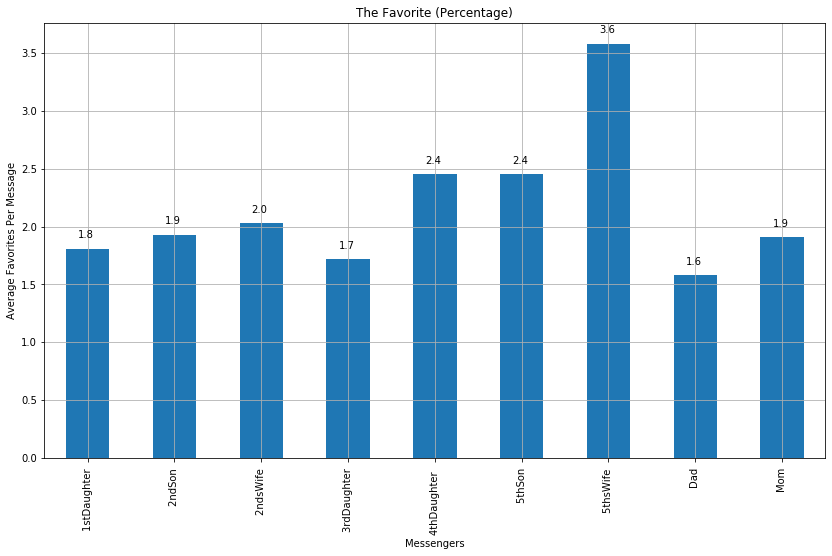

In [18]:
ax = perPerson['Favorites per Message'].plot(kind='bar', 
                                         grid=True, 
                                         figsize=(14,8),
                                         title="The Favorite (Percentage)")
ax.set(xlabel="Messengers", ylabel="Average Favorites Per Message")
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),1)), (p.get_x() +.14, p.get_height() +.09))

# Analysis of message contents per person

1stDaughter 


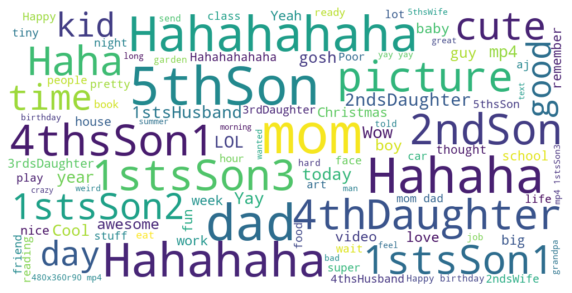

2ndSon 


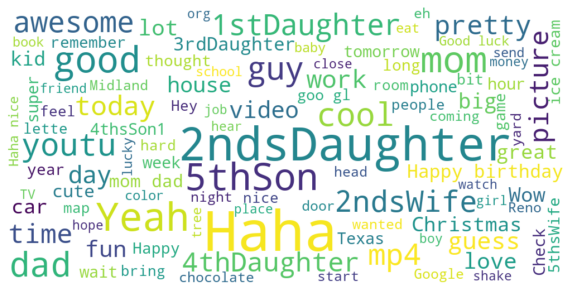

2ndsWife 


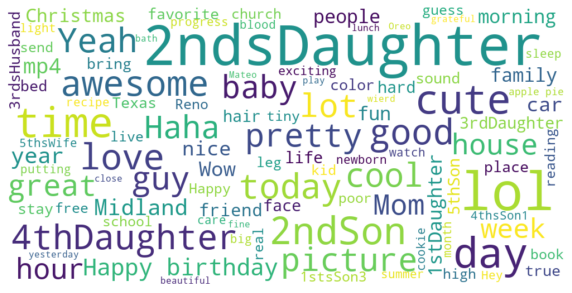

3rdDaughter 


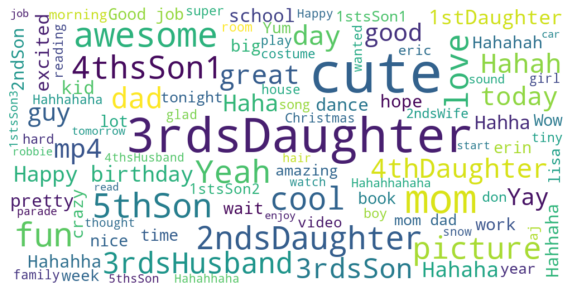

4thDaughter  


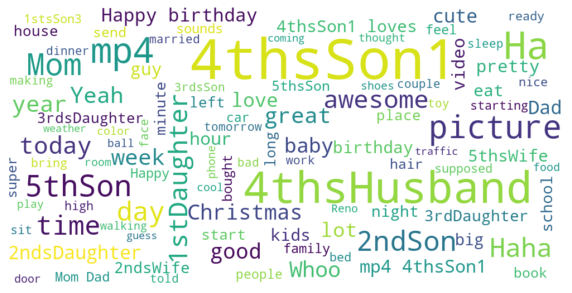

5thSon 


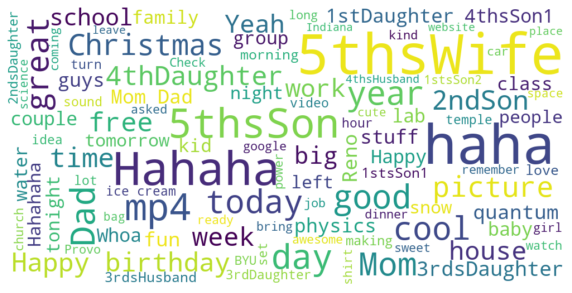

5thsWife 


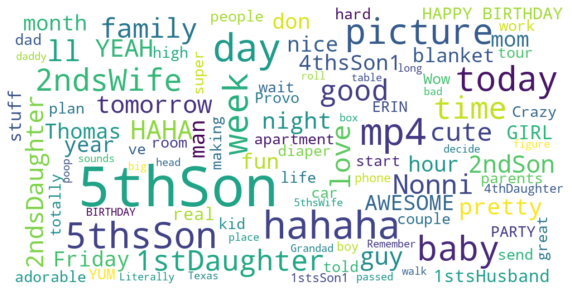

Dad 


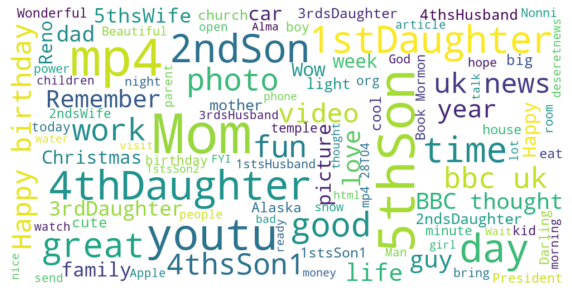

Mom 


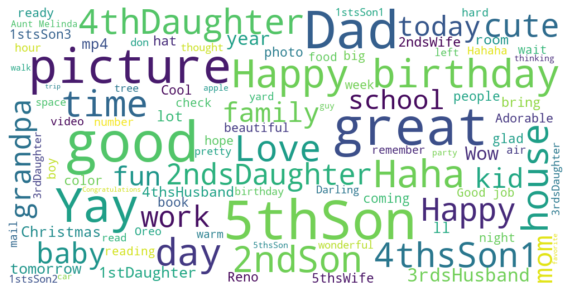

In [19]:
stopwords = set(line.strip() for line in open('stopwords1.txt'))
stopwords = stopwords.union(set(['https','groupme','640x360r90', '568x320r90','http','640x360r','mp4https']))

for x in list(perPerson.index):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=stopwords, 
                          width=1000, 
                          height=500,
                          max_font_size=100, 
                          max_words=100, 
                          background_color="white").generate(perPerson.loc[x]['Messages'])
    print(x)
    # Display the generated image:
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#     # Save the image in the img folder:
#     wordcloud.to_file("Analbumcover/"+x+"_WC.png")

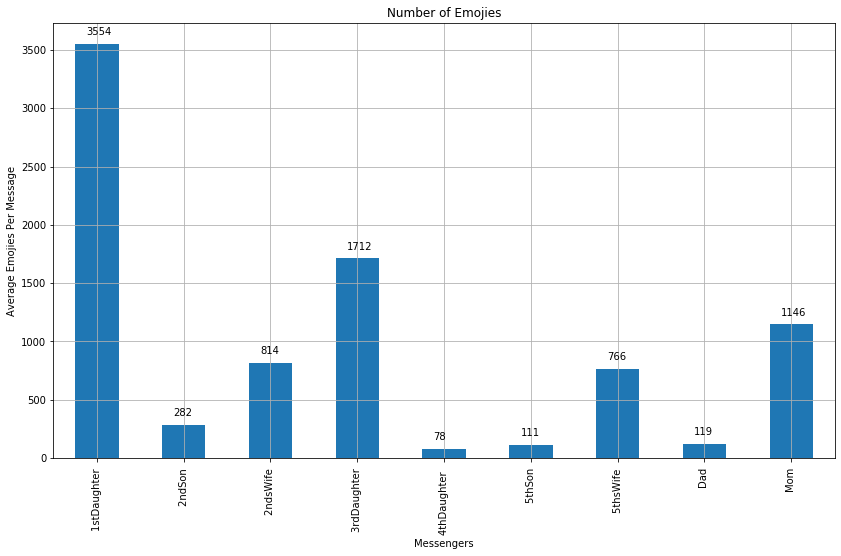

In [27]:
ax = perPerson['Number of Emojis'].plot(kind='bar', 
                                        grid=True, 
                                        figsize=(14,8),
                                        title="Number of Emojies")
ax.set(xlabel="Messengers", ylabel="Average Emojies Per Message")
for p in ax.patches:
    ax.annotate(round(p.get_height(),1), (p.get_x() + .13, p.get_height() + 75))

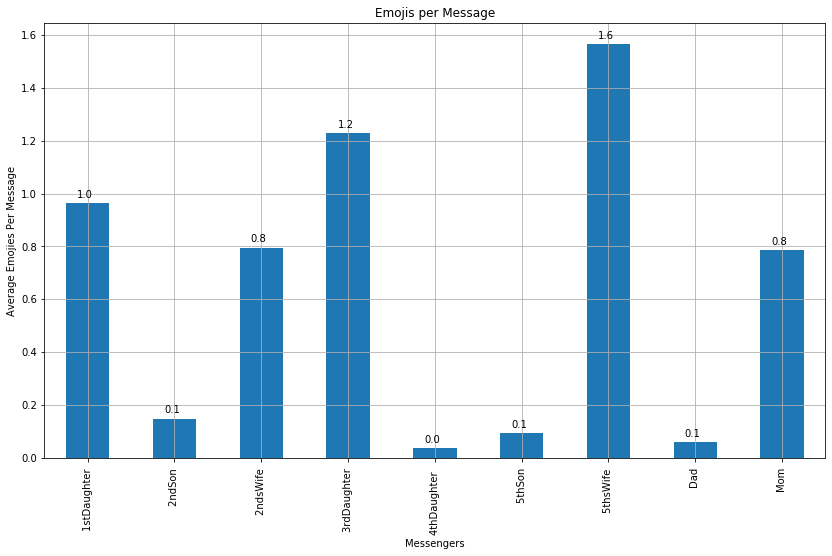

In [72]:
ax = perPerson['Emojis per Message'].plot(kind='bar', 
                                          grid=True, 
                                          figsize=(14,8),
                                          title="Emojis per Message")
ax.set(xlabel="Messengers", ylabel="Average Emojies Per Message")
for p in ax.patches:
    ax.annotate(round(p.get_height(),1), (p.get_x() + .13, p.get_height() +.02))

# Analysis of messages through time

In [73]:
messages.head()

,attachments,avatar_url,created_at,event,favorited_by,group_id,id,name,sender_id,sender_type,source_guid,system,text,user_id
0,[],https://i.groupme.com/500x500.jpeg.a6ac00ef65e...,2018-12-13 18:41:52-08:00,NaN,[],22733073,154475531298454519,2ndSon,38965011,user,f0be0d525631ff699e0705c559aac48b,False,I copied it to youtube.,38965011
1,[],https://i.groupme.com/500x500.jpeg.a6ac00ef65e...,2018-12-13 18:41:44-08:00,NaN,[],22733073,154475530404448439,2ndSon,38965011,user,29a2b6560ff905ae3aae85d78d8c41fd,False,Here you go 5thsWife - https://www.youtube.com...,38965011
2,[],https://i.groupme.com/638x638.jpeg.115fb32058f...,2018-12-13 15:58:09-08:00,NaN,[],22733073,154474548926793168,5thsWife,48321288,user,4A969769-EB78-4354-A00E-BB62814DB7F5,False,....won’t let me watch it! Hey,48321288
3,[],https://i.groupme.com/1632x918.png.bab44dae5f4...,2018-12-13 15:39:58-08:00,NaN,[38965011],22733073,154474439894152940,5thSon,38964800,user,android-eca69dd2-e52d-4a77-8a70-4176335d16d4,False,https://drive.google.com/file/d/17MWfVdqviGdUp...,38964800
4,[],https://i.groupme.com/907x1300.png.111c73c24d1...,2018-12-13 10:31:39-08:00,NaN,[],22733073,154472589915523168,2ndsWife,38964804,user,android-8006876f-e71a-4ac2-9c94-b732d2237e5b,False,Cuuuuuute! The snow was CRAZY this morning!,38964804


In [ ]:
for day, frame in messages.groupby('Date'):

In [39]:
messageTimes = {}
for index, row in messages.iterrows():
    messageTime = datetime.utcfromtimestamp(row['created_at']).strftime('%Y-%m')
    if messageTime not in messageTimes:
        messageTimes[messageTime] = 1
    else:
        messageTimes[messageTime] += 1
    #print(messageTimes)
    
labels = ['messages']
throughTime = pd.DataFrame.from_dict(messageTimes, orient='index', columns=labels)
throughTime.index = pd.to_datetime(throughTime.index)
#print(len(throughTime))

for x in list(perPerson.index):
    tdf = messages.loc[messages['name'] == x]
    #print(list(tdf))
    messageTimes ={}
    for index, row in tdf.iterrows():
        messageTime = datetime.utcfromtimestamp(row['created_at']).strftime('%Y-%m')
        #print(messageTime)
        if messageTime not in messageTimes:
            messageTimes[messageTime] = 1
        else:
            messageTimes[messageTime] += 1
    #print(len(messageTimes))
    labels = [x.split()[0]]
    tdf2 = pd.DataFrame.from_dict(messageTimes, orient='index', columns=labels)
    tdf2.index = pd.to_datetime(tdf2.index)
    #print(len(tdf2))
    throughTime = throughTime.merge(tdf2, left_index=True, right_index=True, how="left")

#throughTime.index = pd.to_datetime(throughTime.index)
#print(len(throughTime))
throughTime.head()

# data_perc = throughTime.drop(columns=['messages'])
# data_perc = data_perc.divide(data_perc.sum(axis=1), axis=0)

# messages.head()

,messages,1stDaughter,2ndSon,2ndsWife,3rdDaughter,4thDaughter,5thSon,5thsWife,Dad,Mom
2018-12-01,233,51,39,9,24,41,20,16.0,10,23
2018-11-01,545,135,78,15,52,77,32,40.0,38,78
2018-10-01,497,126,48,46,46,70,34,26.0,36,65
2018-09-01,516,110,96,18,69,72,39,33.0,32,47
2018-08-01,470,70,62,30,65,76,55,17.0,38,57


In [ ]:
times = []
for index, row in messages.iterrows():
    hour = datetime.fromtimestamp(row['created_at'])
    
    hour = hour.strftime('%H')
    times.append(hour)
messages['hour_posted'] = times
messages['hour_posted'] = messages['hour_posted'].astype(np.int64)
print(messages.head())

In [ ]:
ax = throughTime.plot.area(y=['David','Marianne','Erin','Eric', 'Hannah','Rachel', 'Lisa',  'Marysa', 'AJ' ],figsize=(15,5));
ax.set_ylabel('Messages')
plt.show()

In [ ]:
ax = data_perc.plot.area(y=['David','Marianne','Erin','Eric', 'Hannah','Rachel', 'Lisa',  'Marysa', 'AJ' ],figsize=(15,5));
ax.set_ylabel('Messages')
plt.show()

In [ ]:
throughTime.plot(y=['Eric', 'Marysa', 'AJ', 'Rachel', 'Lisa', 'Hannah', 'Erin', 'Marianne', 'David'],figsize=(15,5))

In [ ]:
tMessages = messages[messages.name != 'Aj Rasmusson']
tMessages = tMessages[tMessages.name != 'GroupMe']
tMessages = tMessages[tMessages.name != 'Marysa Rasmusson']
tMessages.hist(column='hour_posted', by='name', figsize=(15,14), bins=24)

In [ ]:
messages.loc[messages['text'] != "None"]

# Sentiment

In [ ]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

eric_text = perPerson.loc['Eric Rasmusson']['text']
eric_text = REPLACE_NO_SPACE.sub("", eric_text)
eric_text = REPLACE_WITH_SPACE.sub(" ", eric_text)

cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)


print(eric_text)